# All Modules Functionality Workbook

This notebook demonstrates all steps of the workflow: fetching, transforming, training, inference, and simulation.

In [1]:
import matplotlib.pyplot as plt
from scripts.data_repo import DataRepository
from scripts.transform import TransformData
from scripts.train import TrainModel
import warnings

In [2]:
# workflow settings
FETCH_REPO = False
TRANSFORM_DATA = False
TRAIN_MODEL = False

# 1) Fetching data from API / Loading from a local storage

In [3]:
repo = DataRepository()
if FETCH_REPO:
    # Fetch All 3 datasets for all dates from APIs
    repo.fetch()
    # save data to a local dir
    repo.persist(data_dir="local_data/")
else:
    # OR Load from disk
    repo.load(data_dir="local_data/")


# DEBUG: Separate fetching of the datasets (YFinance-Tickers, YFinance-Indexes, FRED-Macro)
# repo.fetch_indexes()
# repo.fetch_tickers()
# repo.fetch_macro()

In [4]:
repo.ticker_df.Date.agg({"min", "max", "count"})

min      1970-01-02
count        654755
max      2024-07-12
Name: Date, dtype: object

In [5]:
repo.ticker_df.Ticker.nunique()

74

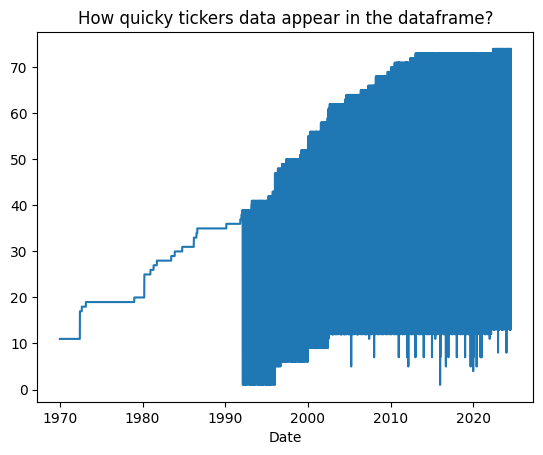

In [6]:
repo.ticker_df.groupby("Date")["Open"].agg("count").plot()
plt.title("How quicky tickers data appear in the dataframe?")
plt.show()

In [7]:
repo.indexes_df.shape

(13752, 49)

In [8]:
repo.indexes_df.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,1.005517,1.00688,1.019303,1.066148,1.094407,1.379503,1.011525,1.028076,1.020335,1.013528,...,0.985969,1.017105,1.026932,1.001531,1.00967,0.998108,1.021833,0.848453,0.90721,1.839477


In [9]:
repo.macro_df.tail(1)

,DGS1,DGS5,Date,Quarter,gdppot_us_yoy,gdppot_us_qoq,Month,FEDFUNDS,cpi_core_yoy,cpi_core_mom,DGS10
DATE,,,,,,,,,,,
2024-07-11,4.91,4.13,2024-07-11,2024-07-01,0.020675,0.005201,2024-07-01,5.33,0.032769,0.000648,4.2


# 2) Transform all input fields (data_repo dfs) to one dataframe

In [10]:
transformed = TransformData(repo=repo)

if TRANSFORM_DATA:
    transformed.transform()
    transformed.persist(data_dir="local_data/")
else:
    transformed.load(data_dir="local_data/")

In [11]:
transformed.transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424027 entries, 3490 to 5472
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(128), int32(65), int64(5), object(2)
memory usage: 554.8+ MB


In [12]:
transformed.transformed_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5471,3660.0,3684.600098,3603.000000,3621.100098,3621.100098,2942924.0,INDIA,LT.NS,2024,7,...,0.986143,1.014011,1.022142,0.985460,0.993115,1.011283,1.006445,0.851674,0.853399,1.886864
5472,3630.0,3667.699951,3612.699951,3649.350098,3649.350098,2001185.0,INDIA,LT.NS,2024,7,...,0.985969,1.017105,1.026932,1.001531,1.009670,0.998108,1.021833,0.848453,0.907210,1.839477


In [13]:
# last 3 days of the data
transformed.transformed_df.tail(3)["Date"]

5470   2024-07-10 00:00:00+00:00
5471   2024-07-11 00:00:00+00:00
5472   2024-07-12 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# 3) Train the best model 
* Model : Random Forest(max_depth=17, n_estimators=200)

In [14]:
# Suppress all warnings (not recommended in production unless necessary)
warnings.filterwarnings("ignore")

trained = TrainModel(transformed=transformed)

if TRAIN_MODEL:
    trained.prepare_dataframe()  # prepare dataframes
    trained.train_random_forest()  # train the model
    trained.persist(data_dir="local_data/")  # save the model to disk
else:
    trained.prepare_dataframe()  # prepare dataframes (incl. for inference)
    trained.load(data_dir="local_data/")

Prepare the dataframe: define feature sets, add dummies, temporal split
length: X_train (288465, 281),  X_validation (67655, 281), X_test (67907, 281)
  X_train_valid = (356120, 281),  all combined: X_all (424027, 281)


In [15]:
# resulting df
trained.df_full.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_UNH,Ticker_V,Ticker_VZ,Ticker_WFC,Ticker_WMT,Ticker_XOM,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split
5471,3660.0,3684.600098,3603.000000,3621.100098,3621.100098,2942924.0,INDIA,LT.NS,2024,7,...,0,0,0,0,0,0,0,1,0,test
5472,3630.0,3667.699951,3612.699951,3649.350098,3649.350098,2001185.0,INDIA,LT.NS,2024,7,...,0,0,0,0,0,0,0,1,0,test


# 4) Inference

In [16]:
prediction_name = "pred_rf_best"
trained.make_inference(pred_name=prediction_name)

Making inference


: 

In [ ]:
trained.df_full

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split,pred_rf_best,pred_rf_best_rank
3490,58.687500,59.312500,56.000000,58.281250,36.000641,53228400.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.309806,15.0
3491,56.781250,58.562500,56.125000,56.312500,34.784519,54119000.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.342859,18.0
3492,55.562500,58.187500,54.687500,56.906250,35.151291,64059600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.325726,20.0
3493,56.093750,56.937500,54.187500,55.000000,33.973804,54976600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.297328,21.0
3494,54.312500,56.125000,53.656250,55.718750,34.417755,62013600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.663156,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,3708.000000,3710.000000,3675.000000,3689.199951,3660.425781,1936792.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.499269,11.0
5455,3690.000000,3699.000000,3575.000000,3589.949951,3561.949951,2936151.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.534216,2.0
5456,3584.949951,3613.300049,3564.600098,3594.449951,3594.449951,2618715.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.451569,21.0
5457,3604.050049,3610.000000,3516.000000,3535.000000,3535.000000,4508508.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.530128,26.0


In [ ]:
COLUMNS = ["Adj Close", "Ticker", "Date", prediction_name, prediction_name + "_rank"]
trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1].sort_values(
    by="Date"
).tail(10)[COLUMNS]

,Adj Close,Ticker,Date,pred_rf_best,pred_rf_best_rank
4085,274.670013,V,2024-06-11 00:00:00+00:00,0.536564,1.0
11153,191.529999,JPM,2024-06-12 00:00:00+00:00,0.534757,1.0
11154,193.660004,JPM,2024-06-13 00:00:00+00:00,0.555324,1.0
8219,64.932053,TTE,2024-06-14 00:00:00+00:00,0.571235,1.0
4089,271.170013,V,2024-06-17 00:00:00+00:00,0.564716,1.0
6817,182.809998,AMZN,2024-06-18 00:00:00+00:00,0.536077,1.0
5452,1392.349976,BHARTIARTL.NS,2024-06-19 00:00:00+00:00,0.606364,1.0
8222,66.480003,TTE,2024-06-20 00:00:00+00:00,0.491225,1.0
5425,3810.750000,TCS.NS,2024-06-21 00:00:00+00:00,0.602811,1.0
5455,1419.849976,BHARTIARTL.NS,2024-06-24 00:00:00+00:00,0.698272,1.0


In [ ]:
print(
    trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1]
    .sort_values(by="Date")
    .tail(10)[COLUMNS]
)

         Adj Close         Ticker                      Date  pred_rf_best  \
4085    274.670013              V 2024-06-11 00:00:00+00:00      0.536564   
11153   191.529999            JPM 2024-06-12 00:00:00+00:00      0.534757   
11154   193.660004            JPM 2024-06-13 00:00:00+00:00      0.555324   
8219     64.932053            TTE 2024-06-14 00:00:00+00:00      0.571235   
4089    271.170013              V 2024-06-17 00:00:00+00:00      0.564716   
6817    182.809998           AMZN 2024-06-18 00:00:00+00:00      0.536077   
5452   1392.349976  BHARTIARTL.NS 2024-06-19 00:00:00+00:00      0.606364   
8222     66.480003            TTE 2024-06-20 00:00:00+00:00      0.491225   
5425   3810.750000         TCS.NS 2024-06-21 00:00:00+00:00      0.602811   
5455   1419.849976  BHARTIARTL.NS 2024-06-24 00:00:00+00:00      0.698272   

       pred_rf_best_rank  
4085                 1.0  
11153                1.0  
11154                1.0  
8219                 1.0  
4089             